<a href="https://colab.research.google.com/github/ChaosLord003/Diabetetes-Prediction/blob/main/Copy_of_Diabetes_Prediction_using_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diabetes-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3102947%2F5344155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240603%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240603T163151Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D54ad474b775af80833ae501ab20001aea081b757b5a8f3053a073d9208264d5fab5b683a2941117e8f6cbe4e2eff5471337138550b2254934cd8b71055e34c82f55c56d42b2b35df46f857158d1fe237d945e4d5363840b2bc55a8052b62d731ceba09b4aa51e3153c738b53c58a1bfd9d9c287284034d52774fd65f90835e2e3443be6b761870cb65a640c9c536b9f4bdb96d6e06be4fcc4f4346d632809547f895c28ff7eb121995402418c1624b361f3862179a2913e96fa3a4345ef6d67279e502195f2b57ae14189be8bdc9b4ed49af2369d8b02c0098745e9fa6cf06ac800649d14a91cc306a848a9f16c41f6d196d06226700d6e310bcdb57241bc892'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 751272 bytes downloaded
Downloaded and uncompressed: diabetes-prediction-dataset
Data source import complete.


# **Predicting Diabetes using KNN classifier model**

[![Screenshot 2024-06-01 at 1.04.36 PM.png](attachment:9d752b0c-258e-44c0-91fa-a772ac655bba.png)](http://)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


# **Import the data**

In [ ]:
# Importing dataset into Pandas Dataframe
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

In [ ]:
# Displaying first 10 rows from the dataset
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


# **Explore the Data**

In [ ]:
# Displaying summary statistics of the attributes
df.describe(include="all")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


In [ ]:
# Dispaying number of rows and columns
df.shape

(100000, 9)

In [ ]:
# Displaying the datatype of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
# Checking null values in the dataset
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
# Displaying number of males and females
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

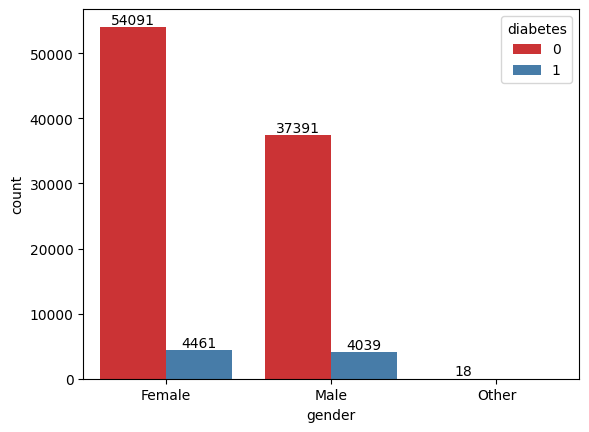

In [ ]:
# Visualising the distribution between Gender and Diabetes
ax = sns.countplot(x='gender', hue='diabetes', data=df, palette= "Set1")
for label in ax.containers:
    ax.bar_label(label)
plt.show()

***We can see that there is a slight difference between male and females having diabetes and we see that the count of females is slightly higher than that of males***

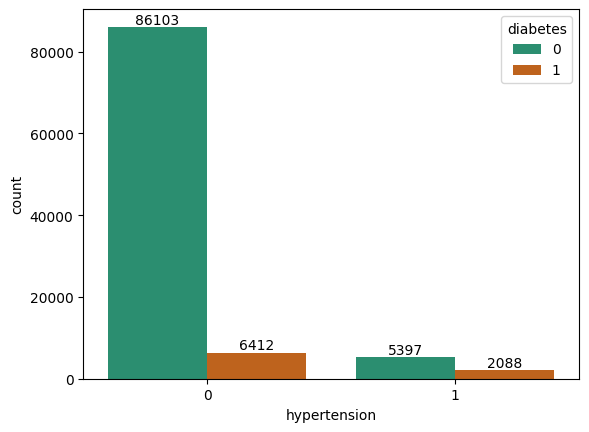

In [ ]:
# Visualising the distribution between Hyptertension and Diabetes
bx = sns.countplot(x='hypertension', hue='diabetes', data=df, palette='Dark2')
for label in bx.containers:
    bx.bar_label(label)
plt.show()

***We can see that patients having hypertension are more prone to diabetes compared to those who dont have hypertension***

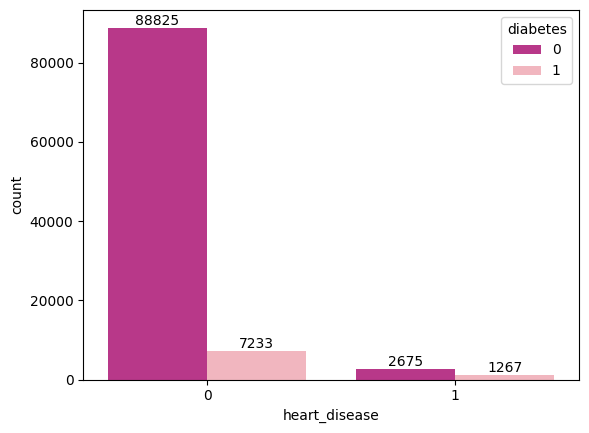

In [ ]:
# Visualising the distribution between Heart_disease and Diabetes
cx = sns.countplot(x='heart_disease', hue='diabetes', data=df, palette='RdPu_r')
for label in cx.containers:
    cx.bar_label(label)
plt.show()

***We can observe that patients with heart disease are at high risk of getting diabetes***

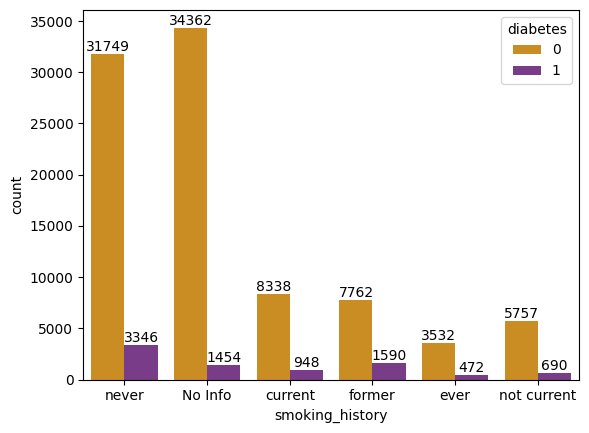

In [ ]:
# Visualising the distribution between smoking_history and Diabetes
dx = sns.countplot(x='smoking_history', hue='diabetes', data=df, palette='CMRmap_r')
for label in dx.containers:
    dx.bar_label(label)
plt.show()

<Axes: xlabel='diabetes', ylabel='bmi'>

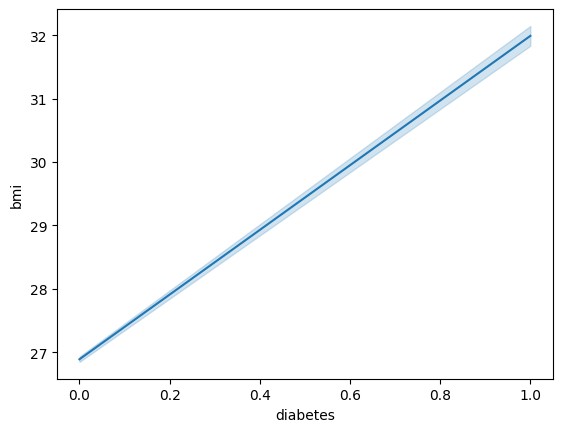

In [ ]:
# Visualising the relationship between BMI and Diabetes
sns.lineplot(y='bmi', x='diabetes', data=df)

***We can see a linear relationship between people with high BMI and diabetes. We can state that people with high BMI index are more prone to diabetes***

<Axes: xlabel='HbA1c_level', ylabel='diabetes'>

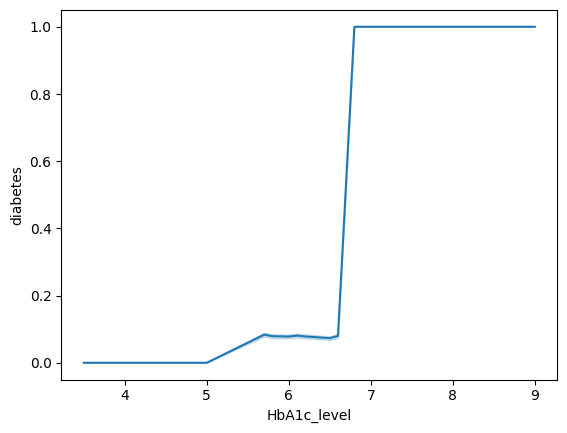

In [ ]:
# Visualising the relationship between HbA1c_level and Diabetes
sns.lineplot(x='HbA1c_level', y='diabetes', data=df)

***We observe that as the Hemoglobin A1c (average blood sugar level) increases we see a sudden sharp increase in diabetes***

<Axes: xlabel='blood_glucose_level', ylabel='diabetes'>

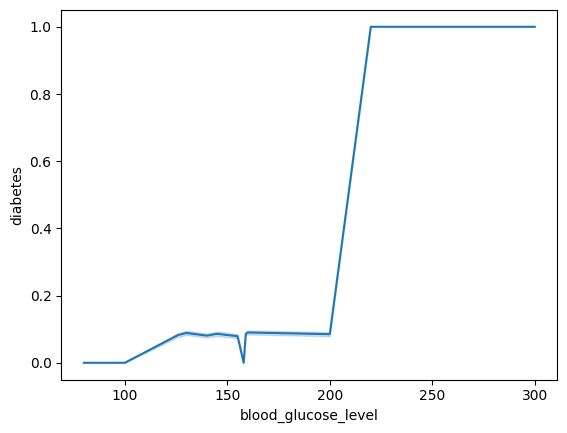

In [ ]:
# Visualising the relationship between blood_glucose_level and Diabetes
sns.lineplot(x='blood_glucose_level', y='diabetes', data=df)

***We observe that as the amount of glucose in bloodstream reaches 200 we see an increase in diabetes***

<Axes: xlabel='age', ylabel='diabetes'>

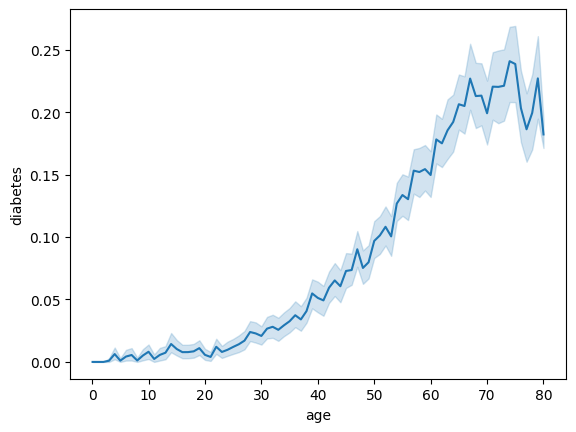

In [ ]:
# Visualising the relationship between Age and Diabetes
sns.lineplot(x='age', y='diabetes', data=df)

***The relationship between age and diabetes is an exponential increase***

# **Feature Engineering**

In [ ]:
# Using .get_dummies function to convert the categorical datatype to numerical and storing the returned dataFrame in a new variable df1
df1 = pd.get_dummies(df['gender'])

In [ ]:
# Using pd.concat to concatenate the dataframes df and df1 and storing the concatenated dataFrame in df.
df = pd.concat([df, df1], axis=1).reindex(df.index)

In [ ]:
# Removing the column 'gender' from df as it is of no use now.
df.drop('gender', axis=1, inplace=True)

In [ ]:
# We use .map() on a specific column and provide a dictionary to perform the mapping
df['Female'] = df['Female'].map({True: 1, False: 0})
df['Male'] = df['Male'].map({True: 1, False: 0})
df['Other'] = df['Other'].map({True: 1, False: 0})

In [ ]:
df.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other
0,80.0,0,1,never,25.19,6.6,140,0,1,0,0
1,54.0,0,0,No Info,27.32,6.6,80,0,1,0,0
2,28.0,0,0,never,27.32,5.7,158,0,0,1,0
3,36.0,0,0,current,23.45,5.0,155,0,1,0,0
4,76.0,1,1,current,20.14,4.8,155,0,0,1,0


In [ ]:
# Drop the 'smoking_history' column as it is non-numeric and we do not handle it here
df = df.drop(columns=['smoking_history'])

In [ ]:
# Define the feature set (X) and the target variable (y)
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# **Splitting the data into train and test**

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Training the Model using KNN classifier**

In [ ]:
# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Make predictions
y_pred = knn.predict(X_test_scaled)

# **Evaluating the model**

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Print the evaluation results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.9618
Confusion Matrix:
[[18100   192]
 [  572  1136]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18292
           1       0.86      0.67      0.75      1708

    accuracy                           0.96     20000
   macro avg       0.91      0.83      0.86     20000
weighted avg       0.96      0.96      0.96     20000



In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a smaller subset for initial testing
X_train_small, _, y_train_small, _ = train_test_split(X_train_scaled, y_train, test_size=0.8, random_state=42)


In [ ]:
# Define a smaller range of k values to test
k_values = list(range(1, 11))

# Use RandomizedSearchCV instead of GridSearchCV
param_dist = {'n_neighbors': k_values}
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_small, y_train_small)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get the best k value and the corresponding accuracy
best_k = random_search.best_params_['n_neighbors']
best_accuracy = random_search.best_score_

print(f'Best k value: {best_k}')
print(f'Best cross-validated accuracy: {best_accuracy}')


Best k value: 9
Best cross-validated accuracy: 0.9625


In [ ]:
# Train the final model with the best k value
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=9)

In [ ]:
# Make predictions and evaluate the final model
y_pred_best = knn_best.predict(X_test_scaled)

accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

print(f'Accuracy with best k: {accuracy_best}')
print(f'Confusion Matrix with best k:\n{conf_matrix_best}')
print(f'Classification Report with best k:\n{class_report_best}')

Accuracy with best k: 0.9647
Confusion Matrix with best k:
[[18230    62]
 [  644  1064]]
Classification Report with best k:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.94      0.62      0.75      1708

    accuracy                           0.96     20000
   macro avg       0.96      0.81      0.87     20000
weighted avg       0.96      0.96      0.96     20000

